# A simple MNIst Digits classification using PyTorch

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

ImportError: cannot import name 'equal_valued' from 'sympy.core.numbers' (C:\Anaconda3\lib\site-packages\sympy\core\numbers.py)

In [2]:
#pytorch utility imports
import torch
from torch.utils.data import DataLoader, TensorDataset
#neural net imports
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.autograd import Variable
#import external libraries
import pandas as pd,numpy as np,matplotlib.pyplot as plt, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline


### Set device to GPU or CPU based on availability

In [10]:

#
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cpu')

### Loading MNIST data 

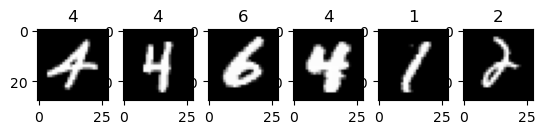

In [4]:

input_folder_path = "MNIST_data/"
#The CSV contains a flat file of images,
#i.e. each 28*28 image is flattened into a row of 784 colums
#(1 column represents a pixel value)
#For CNN, we would need to reshape this to our desired shape
train_df = pd.read_csv(input_folder_path+"mnist_train.csv")
#First column is the target/label
train_labels = train_df['label'].values
#Pixels values start from the 2nd column
train_images = (train_df.iloc[:,1:].values).astype('float32')
#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(
                                             train_images
                                             ,train_labels
                                             ,random_state=2020
                                             ,test_size=0.2)
#Here we reshape the flat row into [#images,#Channels,#Width,#Height]
#Given this a simple grayscale image, we will have just 1 channel
train_images = train_images.reshape(train_images.shape[0],1,28, 28)
val_images = val_images.reshape(val_images.shape[0],1,28, 28)
#Also, let's plot few samples
for i in range(0, 6):
    plt.subplot(160 + (i+1))
    plt.imshow(train_images[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

### Covert Train Images from pandas/numpy to tensor and normalize the values

In [5]:
#Covert Train Images from pandas/numpy to tensor and normalize the values
train_images_tensor = torch.tensor(train_images)/255.0
train_images_tensor = train_images_tensor.view(-1,1,28,28)
train_labels_tensor = torch.tensor(train_labels)
#Create a train TensorDataset
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
#Covert Validation Images from pandas/numpy to tensor and normalize the values
val_images_tensor = torch.tensor(val_images)/255.0
val_images_tensor = val_images_tensor.view(-1,1,28,28)
val_labels_tensor = torch.tensor(val_labels)
#Create a Validation TensorDataset
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)
print("Train Labels Shape:",train_labels_tensor.shape)
print("Train Images Shape:",train_images_tensor.shape)
print("Validation Labels Shape:",val_labels_tensor.shape)
print("Validation Images Shape:",val_images_tensor.shape)
#Load Train and Validation TensorDatasets into the data generator for Training
train_loader = DataLoader(train_tensor, batch_size=64
                          , num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=64, num_workers=2, shuffle=True)



Train Labels Shape: torch.Size([48000])
Train Images Shape: torch.Size([48000, 1, 28, 28])
Validation Labels Shape: torch.Size([12000])
Validation Images Shape: torch.Size([12000, 1, 28, 28])


## Define network

In [6]:
#Define conv-net
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        #First unit of convolution
        self.conv_unit_1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #Second unit of convolution
        self.conv_unit_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #Fully connected layers
        self.fc1 = nn.Linear(7*7*32, 128)
        self.fc2 = nn.Linear(128, 10)
    #Connect the units
    def forward(self, x):
        out = self.conv_unit_1(x)
        out = self.conv_unit_2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = F.log_softmax(out,dim=1)
        return out
#Define Functions for Model Evaluation and generating Predictions
def make_predictions(data_loader):
    #Explcitly set the model to eval mode
    model.eval()
    test_preds = torch.LongTensor()
    actual = torch.LongTensor()
    for data, target in data_loader:
        if torch.cuda.is_available():
            data = data.cuda()
        output = model(data)
        #Predict output/Take the index of the output with max value
        preds = output.cpu().data.max(1, keepdim=True)[1]
        #Combine tensors from each batch
        test_preds = torch.cat((test_preds, preds), dim=0)
        actual  = torch.cat((actual,target),dim=0)
    return actual,test_preds
#Evalute model
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    for data, target in data_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).data.item()
        predicted = output.data.max(1, keepdim=True)[1]
        correct += (target.reshape(-1,1) == predicted.reshape(-1,1)).float().sum()
    loss /= len(data_loader.dataset)
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    

In [7]:
#Create Model  instance
model = ConvNet(10).to(device)
#Define Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

ConvNet(
  (conv_unit_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_unit_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Training 

In [8]:
num_epochs = 5
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #After each epoch print Train loss and validation loss + accuracy
    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss.item()))
    evaluate(val_loader)

Epoch [1/5], Loss: 0.0243


/Users/atif/opt/anaconda3/envs/tf/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: 0.0718, Val Accuracy: 11722.0/12000 (97.683%)

Epoch [2/5], Loss: 0.0139

Average Val Loss: 0.0471, Val Accuracy: 11816.0/12000 (98.467%)

Epoch [3/5], Loss: 0.1336

Average Val Loss: 0.0572, Val Accuracy: 11795.0/12000 (98.292%)

Epoch [4/5], Loss: 0.1206

Average Val Loss: 0.0463, Val Accuracy: 11837.0/12000 (98.642%)

Epoch [5/5], Loss: 0.0062

Average Val Loss: 0.0472, Val Accuracy: 11842.0/12000 (98.683%)



### Predictions and accuracy 

In [9]:
#Make Predictions on Validation Dataset
actual, predicted = make_predictions(val_loader)
actual,predicted = np.array(actual).reshape(-1,1),np.array(predicted).reshape(-1,1)
print("Validation Accuracy-",round(accuracy_score(actual,predicted),4)*100)
print("\n Confusion Matrix\n",confusion_matrix(actual,predicted))

Validation Accuracy- 98.68

 Confusion Matrix
 [[1135    1    2    1    0    3    1    0    3    2]
 [   1 1369    2    1    1    0    0    2    4    0]
 [   0    2 1170    3    2    0    1    2    3    1]
 [   1    1    4 1233    0    7    0    1    4    1]
 [   0    1    0    0 1188    0    1    0    0    1]
 [   0    0    0    1    2 1088    0    0    0    2]
 [   2    0    1    1    4    8 1129    0    3    0]
 [   0    7    2    0   10    1    0 1184    0   15]
 [   1    0    1    1    5    5    0    0 1150    3]
 [   0    0    0    0   12    6    0    2    3 1196]]
